In [202]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import os
from pyspark.sql.functions import col, lit, to_date, split, when, coalesce
from pyspark.sql.types import MapType, StringType
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import year
from pyspark.sql.functions import when, col, count, expr
from itertools import chain
from pyspark.sql.window import Window
from pyspark.sql.functions import udf
from pyspark.sql.types import MapType, StringType
from pyspark.sql.functions import sum
from pyspark.sql.functions import year, floor

In [203]:
spark = SparkSession.builder \
                    .appName('tennis') \
                    .getOrCreate()

In [204]:
folders = ["singles/", "doubles/", "futures/", "qual_chal/"]
file_columns = []
files65 = []
files49= []

In [205]:
for folder in folders:
    for filename in os.listdir(folder):
    
        file_path = os.path.join(folder, filename)
        
        df = spark.read.option("header", "true") \
                       .option("inferSchema", "true") \
                       .csv(file_path)
        
        #file_columns.append({filename:df.columns})
        file_columns.append(df.columns)
        if len(df.columns) == 65:
            files65.append(filename)
        else:
            files49.append(filename)

In [206]:
# Removing duplicates
file_columns = list(set(map(tuple, file_columns)))
file_columns = [list(item) for item in file_columns]
file_columns

[['tourney_id',
  'tourney_name',
  'surface',
  'draw_size',
  'tourney_level',
  'tourney_date',
  'match_num',
  'winner1_id',
  'winner2_id',
  'winner_seed',
  'winner_entry',
  'loser1_id',
  'loser2_id',
  'loser_seed',
  'loser_entry',
  'score',
  'best_of',
  'round',
  'winner1_name',
  'winner1_hand',
  'winner1_ht',
  'winner1_ioc',
  'winner1_age',
  'winner2_name',
  'winner2_hand',
  'winner2_ht',
  'winner2_ioc',
  'winner2_age',
  'loser1_name',
  'loser1_hand',
  'loser1_ht',
  'loser1_ioc',
  'loser1_age',
  'loser2_name',
  'loser2_hand',
  'loser2_ht',
  'loser2_ioc',
  'loser2_age',
  'winner1_rank',
  'winner1_rank_points',
  'winner2_rank',
  'winner2_rank_points',
  'loser1_rank',
  'loser1_rank_points',
  'loser2_rank',
  'loser2_rank_points',
  'minutes',
  'w_ace',
  'w_df',
  'w_svpt',
  'w_1stIn',
  'w_1stWon',
  'w_2ndWon',
  'w_SvGms',
  'w_bpSaved',
  'w_bpFaced',
  'l_ace',
  'l_df',
  'l_svpt',
  'l_1stIn',
  'l_1stWon',
  'l_2ndWon',
  'l_SvGms',
  

In [207]:
print(f"Number of different column sets: {len(file_columns)}")
print(f"Number of columns in the first set: {len(file_columns[0])}")
print(f"Number of columns in the second set: {len(file_columns[1])}")

Number of different column sets: 2
Number of columns in the first set: 65
Number of columns in the second set: 49


In [208]:
col1 = set(file_columns[0])
col2 = set(file_columns[1])
diff1 = col1 - col2 # Columns in Doubles files that are not in Singles files
diff2 = col2 - col1 # Columns in Singles files that are not in Doubles files
# ^ to get both

In [209]:
diff1

{'loser1_age',
 'loser1_hand',
 'loser1_ht',
 'loser1_id',
 'loser1_ioc',
 'loser1_name',
 'loser1_rank',
 'loser1_rank_points',
 'loser2_age',
 'loser2_hand',
 'loser2_ht',
 'loser2_id',
 'loser2_ioc',
 'loser2_name',
 'loser2_rank',
 'loser2_rank_points',
 'winner1_age',
 'winner1_hand',
 'winner1_ht',
 'winner1_id',
 'winner1_ioc',
 'winner1_name',
 'winner1_rank',
 'winner1_rank_points',
 'winner2_age',
 'winner2_hand',
 'winner2_ht',
 'winner2_id',
 'winner2_ioc',
 'winner2_name',
 'winner2_rank',
 'winner2_rank_points'}

In [210]:
diff2

{'loser_age',
 'loser_hand',
 'loser_ht',
 'loser_id',
 'loser_ioc',
 'loser_name',
 'loser_rank',
 'loser_rank_points',
 'winner_age',
 'winner_hand',
 'winner_ht',
 'winner_id',
 'winner_ioc',
 'winner_name',
 'winner_rank',
 'winner_rank_points'}

In [211]:
# Files with 65 columns
files65

['atp_matches_doubles_2018.csv',
 'atp_matches_doubles_2006.csv',
 'atp_matches_doubles_2016.csv',
 '.ipynb_checkpoints',
 'atp_matches_doubles_2008.csv',
 'atp_matches_doubles_2010.csv',
 'atp_matches_doubles_2020.csv',
 'atp_matches_doubles_2009.csv',
 'atp_matches_doubles_2000.csv',
 'atp_matches_doubles_2004.csv',
 'atp_matches_doubles_2013.csv',
 'atp_matches_doubles_2012.csv',
 'atp_matches_doubles_2003.csv',
 'atp_matches_doubles_2015.csv',
 'atp_matches_doubles_2005.csv',
 'atp_matches_doubles_2007.csv',
 'atp_matches_doubles_2001.csv',
 'atp_matches_doubles_2017.csv',
 'atp_matches_doubles_2011.csv',
 'atp_matches_doubles_2002.csv',
 'atp_matches_doubles_2014.csv',
 'atp_matches_doubles_2019.csv']

In [212]:
# Files with 49 columns
files49

['atp_matches_1999.csv',
 'atp_matches_2000.csv',
 'atp_matches_1971.csv',
 'atp_matches_1981.csv',
 'atp_matches_2006.csv',
 'atp_matches_1970.csv',
 'atp_matches_2017.csv',
 'atp_matches_1988.csv',
 'atp_matches_2015.csv',
 'atp_matches_1978.csv',
 'atp_matches_2010.csv',
 'atp_matches_2023.csv',
 'atp_matches_1977.csv',
 'atp_matches_1994.csv',
 'atp_matches_2014.csv',
 'atp_matches_2012.csv',
 'atp_matches_1980.csv',
 'atp_matches_2002.csv',
 'atp_matches_1991.csv',
 'atp_matches_2021.csv',
 'atp_matches_2016.csv',
 'atp_matches_2011.csv',
 'atp_matches_1998.csv',
 'atp_matches_1987.csv',
 'atp_matches_2007.csv',
 'atp_matches_1996.csv',
 'atp_matches_1976.csv',
 'atp_matches_1975.csv',
 'atp_matches_1979.csv',
 'atp_matches_2005.csv',
 'atp_matches_1969.csv',
 'atp_matches_2001.csv',
 'atp_matches_2020.csv',
 'atp_matches_2009.csv',
 'atp_matches_2004.csv',
 'atp_matches_1974.csv',
 'atp_matches_1990.csv',
 'atp_matches_1986.csv',
 'atp_matches_1983.csv',
 'atp_matches_1997.csv',


In [213]:
#HELENA

In [214]:
singles=spark.read.option("header","true").option("inferSchema","true") \
.csv('singles')

singles = singles.withColumn(
    "Origin",
    lit('Singles')
)

doubles=spark.read.option("header","true").option("inferSchema","true") \
.csv('doubles')

doubles = doubles.withColumn(
    "Origin",
    lit('Doubles')
)

futures=spark.read.option("header","true").option("inferSchema","true") \
.csv('futures')

futures = futures.withColumn(
    "Origin",
    lit('Futures')
)

qual_chal = spark.read.option("header","true").option("inferSchema","true") \
.csv('qual_chal')

qual_chal = qual_chal.withColumn(
    "Origin",
    lit('Qualificacao_Challenger')
)

amat = spark.read.option("header","true").option("inferSchema","true") \
.csv('atp_matches_amateur.csv')

amat = amat.withColumn(
    "Origin",
    lit('Amateur')
)

In [215]:
matches_completos = singles.unionAll(futures)
matches_completos = matches_completos.unionAll(qual_chal)
matches_completos=matches_completos.unionAll(amat)

In [216]:
colunas_unicas_doubles = list(set(doubles.columns) - set(matches_completos.columns))

for a in colunas_unicas_doubles:
    matches_completos = matches_completos.withColumn(
    a,
    lit(None)
)

sorted_columns = sorted(matches_completos.columns)
matches_completos = matches_completos.select(*sorted_columns)

In [217]:
colunas_unicas_matches_completos = list(set(matches_completos.columns) - set(doubles.columns))

for a in colunas_unicas_matches_completos:
    doubles = doubles.withColumn(
    a,
    lit(None)
)

In [218]:
sorted_columns = sorted(doubles.columns)
doubles = doubles.select(*sorted_columns)
matches_completos=matches_completos.unionAll(doubles)

In [219]:
len(matches_completos.columns)

82

In [220]:
matches_completos.select('tourney_id').show()
matches=matches_completos

+----------+
|tourney_id|
+----------+
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
+----------+
only showing top 20 rows



In [221]:
#LARA

In [222]:
# Listing all columns with the type 'void' and converting to int
void_columns = [col_name for col_name, data_type in matches.dtypes if data_type == 'void']
for col_name in void_columns:
    matches = matches.withColumn(col_name, matches[col_name].cast("int"))

In [223]:
# Converting to int
columns_to_convert = ["draw_size", "loser_id","loser_seed", "best_of", "minutes", "winner_seed",
    "w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon", "w_SvGms", "w_bpSaved", "w_bpFaced",
    "l_ace", "l_df", "l_svpt", "l_1stIn", "l_1stWon", "l_2ndWon", "l_SvGms", "l_bpSaved", "l_bpFaced",
    "winner_rank", "loser_rank", "winner_rank_points", "loser_rank_points", "winner2_hand"
]
for column in columns_to_convert:
    matches = matches.withColumn(column, col(column).cast("integer"))

In [224]:
matches = matches.withColumn("tourney_date", to_date(matches["tourney_date"].cast("string"), "yyyyMMdd"))
matches = matches.withColumn("winner_age", matches["winner_age"].cast("double"))

In [225]:
# Function to get scores for each set
def extrair_sets(scores):
    if scores:
        sets = scores.split(' ')
    else:
        sets = []
    set_values = {}

    if sets:
        for i, set_score in enumerate(sets):
            try:
                set_values[f"set_{i+1}"] = int(set_score)
            except ValueError:
                set_values[f"set_{i+1}"] = set_score

    return set_values

extrair_sets_udf = udf(extrair_sets, MapType(StringType(), StringType()))

# New column with the scores for each set
matches = matches.withColumn("sets", extrair_sets_udf(col("score")))
for i in range(1, 6):  
    matches = matches.withColumn(f"set_{i}", when(col("sets").getItem(f"set_{i}").isNull(), None).otherwise(col("sets").getItem(f"set_{i}")))

matches = matches.drop("sets")

In [226]:
matches.select("set_1", "set_2", "set_3", "set_4", "set_5").show(10)

+------+------+-----+-----+-----+
| set_1| set_2|set_3|set_4|set_5|
+------+------+-----+-----+-----+
|   6-2|   6-2| NULL| NULL| NULL|
|   6-3|   4-6|  6-2| NULL| NULL|
|   6-4|   6-3| NULL| NULL| NULL|
|   6-3|   6-2| NULL| NULL| NULL|
|   6-4|   6-2| NULL| NULL| NULL|
|   4-6|   6-1|  6-3| NULL| NULL|
|6-7(3)|   6-3|  6-4| NULL| NULL|
|   6-4|   6-4| NULL| NULL| NULL|
|   6-2|   7-5| NULL| NULL| NULL|
|   6-2|7-6(2)| NULL| NULL| NULL|
+------+------+-----+-----+-----+
only showing top 10 rows



In [227]:
matches.filter(matches["set_5"].isNotNull()).select("set_5").show(10)

+-----+
|set_5|
+-----+
|  6-1|
|  8-6|
|  6-2|
|  6-4|
|  6-2|
|  8-6|
|  6-3|
|  RET|
|  6-2|
|  6-4|
+-----+
only showing top 10 rows



In [228]:
matches.printSchema()

root
 |-- Origin: string (nullable = false)
 |-- best_of: integer (nullable = true)
 |-- draw_size: integer (nullable = true)
 |-- l_1stIn: integer (nullable = true)
 |-- l_1stWon: integer (nullable = true)
 |-- l_2ndWon: integer (nullable = true)
 |-- l_SvGms: integer (nullable = true)
 |-- l_ace: integer (nullable = true)
 |-- l_bpFaced: integer (nullable = true)
 |-- l_bpSaved: integer (nullable = true)
 |-- l_df: integer (nullable = true)
 |-- l_svpt: integer (nullable = true)
 |-- loser1_age: double (nullable = true)
 |-- loser1_hand: string (nullable = true)
 |-- loser1_ht: integer (nullable = true)
 |-- loser1_id: integer (nullable = true)
 |-- loser1_ioc: string (nullable = true)
 |-- loser1_name: string (nullable = true)
 |-- loser1_rank: integer (nullable = true)
 |-- loser1_rank_points: integer (nullable = true)
 |-- loser2_age: double (nullable = true)
 |-- loser2_hand: string (nullable = true)
 |-- loser2_ht: integer (nullable = true)
 |-- loser2_id: integer (nullable = tr

In [229]:
doubles_columns = ['winner1_age', 'winner1_hand', 'winner1_ht', 'winner1_id', 'winner1_ioc', 'winner1_name', 'winner1_rank', 'winner1_rank_points', 'loser1_age', 'loser1_hand', 'loser1_ht', 'loser1_id', 'loser1_ioc', 'loser1_name', 'loser1_rank', 'loser1_rank_points']
singles_columns = ['winner_age', 'winner_hand', 'winner_ht', 'winner_id', 'winner_ioc', 'winner_name', 'winner_rank', 'winner_rank_points', 'loser_age', 'loser_hand', 'loser_ht', 'loser_id', 'loser_ioc', 'loser_name', 'loser_rank', 'loser_rank_points']

In [230]:
# Transferring the records in singles-related columns to doubles-related columns
for i in range(len(doubles_columns)):
    matches = matches.withColumn(f"{doubles_columns[i]}", coalesce(matches[f"{singles_columns[i]}"], matches[f"{doubles_columns[i]}"]))

In [231]:
# Dropping the columns not needed
matches = matches.drop(*singles_columns)

In [232]:
# 65 + Origin + 5 sets = 71
len(matches.columns)

71

In [233]:
# BEA

In [234]:
matches

DataFrame[Origin: string, best_of: int, draw_size: int, l_1stIn: int, l_1stWon: int, l_2ndWon: int, l_SvGms: int, l_ace: int, l_bpFaced: int, l_bpSaved: int, l_df: int, l_svpt: int, loser1_age: double, loser1_hand: string, loser1_ht: int, loser1_id: int, loser1_ioc: string, loser1_name: string, loser1_rank: int, loser1_rank_points: int, loser2_age: double, loser2_hand: string, loser2_ht: int, loser2_id: int, loser2_ioc: string, loser2_name: string, loser2_rank: int, loser2_rank_points: int, loser_entry: string, loser_seed: int, match_num: int, minutes: int, round: string, score: string, surface: string, tourney_date: date, tourney_id: string, tourney_level: string, tourney_name: string, w_1stIn: int, w_1stWon: int, w_2ndWon: int, w_SvGms: int, w_ace: int, w_bpFaced: int, w_bpSaved: int, w_df: int, w_svpt: int, winner1_age: double, winner1_hand: string, winner1_ht: int, winner1_id: int, winner1_ioc: string, winner1_name: string, winner1_rank: int, winner1_rank_points: int, winner2_age: 

In [235]:
print("-------------------------------------------")
# Count null values in 'Origin' column
null_count = matches.select('Origin').where(col('Origin').isNull()).count()
# Count total values set_1
total_values = matches.select('set_1').count()
print(f"Total null values in 'Origin' column: {null_count}")
print(f"Total values in 'set_1' column: {total_values}")
print("-------------------------------------------")




# Only use until winnner_seed, set_1, set_2, etc... were throwing errors
relevant_columns = matches.columns[: matches.columns.index('winner_seed') + 1]  # Add 1 for inclusive indexing

# Calculate null values counts
null_columns = []
for column in relevant_columns:
    null_value_counts = matches.select(column).where(col(column).isNull()).count()
    # Percentage of null values
    percentage = (null_value_counts / matches.select(column).count()) * 100
    # Print the results
    print(f"Column name: {column} has a total of {null_value_counts} null values and percentage of nulls: {percentage:.2f}%")
    
    
    # If percentage of nulls superior to 75% delete column?
    if percentage >= 75:
        null_columns.append(column)

print("-------------------------------------------")
print("Columns with null percentage superior to 75%")
for column_null in null_columns:
    print(f"Column name: {column_null}")

-------------------------------------------
Total null values in 'Origin' column: 0
Total values in 'set_1' column: 935359
-------------------------------------------
Column name: Origin has a total of 0 null values and percentage of nulls: 0.00%
Column name: best_of has a total of 0 null values and percentage of nulls: 0.00%
Column name: draw_size has a total of 2477 null values and percentage of nulls: 0.26%
Column name: l_1stIn has a total of 730169 null values and percentage of nulls: 78.06%
Column name: l_1stWon has a total of 730169 null values and percentage of nulls: 78.06%
Column name: l_2ndWon has a total of 730169 null values and percentage of nulls: 78.06%
Column name: l_SvGms has a total of 730170 null values and percentage of nulls: 78.06%
Column name: l_ace has a total of 730169 null values and percentage of nulls: 78.06%
Column name: l_bpFaced has a total of 730169 null values and percentage of nulls: 78.06%
Column name: l_bpSaved has a total of 730169 null values and p

In [236]:
matches.repartition(1).write.csv("matches", mode='overwrite')

In [237]:
matches.printSchema()

root
 |-- Origin: string (nullable = false)
 |-- best_of: integer (nullable = true)
 |-- draw_size: integer (nullable = true)
 |-- l_1stIn: integer (nullable = true)
 |-- l_1stWon: integer (nullable = true)
 |-- l_2ndWon: integer (nullable = true)
 |-- l_SvGms: integer (nullable = true)
 |-- l_ace: integer (nullable = true)
 |-- l_bpFaced: integer (nullable = true)
 |-- l_bpSaved: integer (nullable = true)
 |-- l_df: integer (nullable = true)
 |-- l_svpt: integer (nullable = true)
 |-- loser1_age: double (nullable = true)
 |-- loser1_hand: string (nullable = true)
 |-- loser1_ht: integer (nullable = true)
 |-- loser1_id: integer (nullable = true)
 |-- loser1_ioc: string (nullable = true)
 |-- loser1_name: string (nullable = true)
 |-- loser1_rank: integer (nullable = true)
 |-- loser1_rank_points: integer (nullable = true)
 |-- loser2_age: double (nullable = true)
 |-- loser2_hand: string (nullable = true)
 |-- loser2_ht: integer (nullable = true)
 |-- loser2_id: integer (nullable = tr

### Plots - Bea

##### Distribution of player ages (Winners and Losers) 

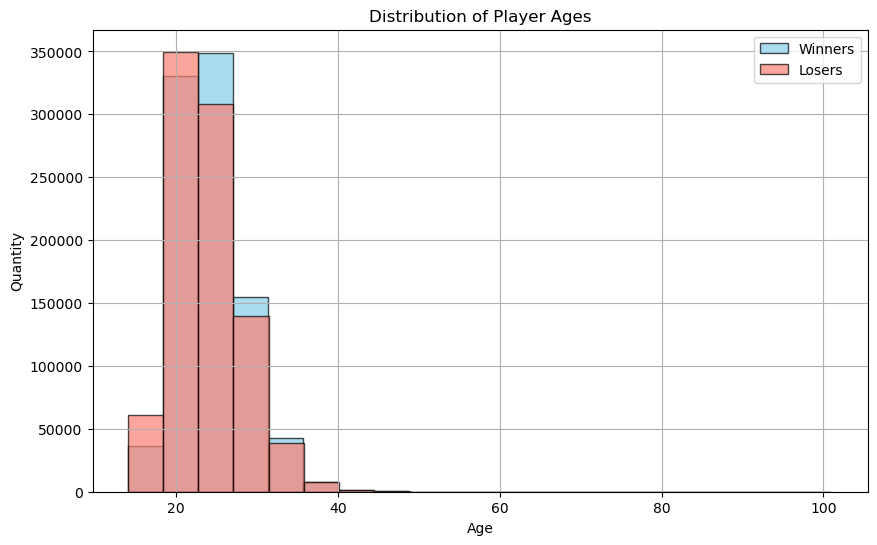

In [238]:
# Drop Null values for age
winner_age_data = matches.select('winner1_age').dropna()
loser_age_data = matches.select('loser1_age').dropna()

winner_age_pandas = winner_age_data.toPandas()
loser_age_pandas = loser_age_data.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(winner_age_pandas['winner1_age'], bins=20, color='skyblue', edgecolor='black', alpha=0.7, label='Winners')
plt.hist(loser_age_pandas['loser1_age'], bins=20, color='salmon', edgecolor='black', alpha=0.7, label='Losers')
plt.title('Distribution of Player Ages')
plt.xlabel('Age')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()

##### Distribution of tournament types (Grand Slams, ATP Tour, Challengers, Futures) - Ver se dá para fazer separação para homem e para mulher

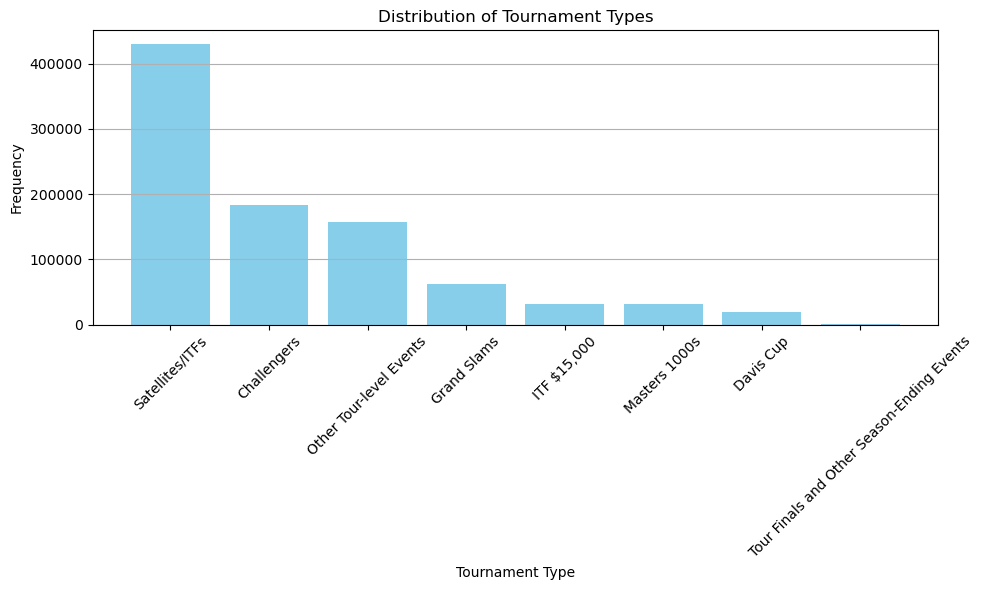

In [239]:
tournament_level_mapping = {
    'G': 'Grand Slams',
    'M': 'Masters 1000s',
    'A': 'Other Tour-level Events',
    'C': 'Challengers',
    'S': 'Satellites/ITFs',
    'F': 'Tour Finals and Other Season-Ending Events',
    'D': 'Davis Cup',
    'P': 'Premier',
    'PM': 'Premier Mandatory',
    'I': 'International',
    '15': 'ITF $15,000',
}

matches = matches.withColumn('tourney_level_desc', F.create_map([F.lit(x) for x in chain(*tournament_level_mapping.items())])[F.col('tourney_level')])

# Filter out rows with missing values in 'tourney_level_desc' column
matches = matches.filter(matches['tourney_level_desc'].isNotNull())

tournament_type_counts = matches.groupby('tourney_level_desc').count().orderBy('count', ascending=False)
tournament_type_counts_pandas = tournament_type_counts.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(tournament_type_counts_pandas['tourney_level_desc'], tournament_type_counts_pandas['count'], color='skyblue')
plt.title('Distribution of Tournament Types')
plt.xlabel('Tournament Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### Analysis of dominant hand (right-handed vs. left-handed) - DAR FIX NO GRÁFICO

Total Winners:
  winner1_hand   count
1            A     288
2            L  103799
3            R  689854
4            U  103319

Total Losers:
  loser1_hand   count
1           A     303
2           L   91286
3           R  643254
4           U  160815


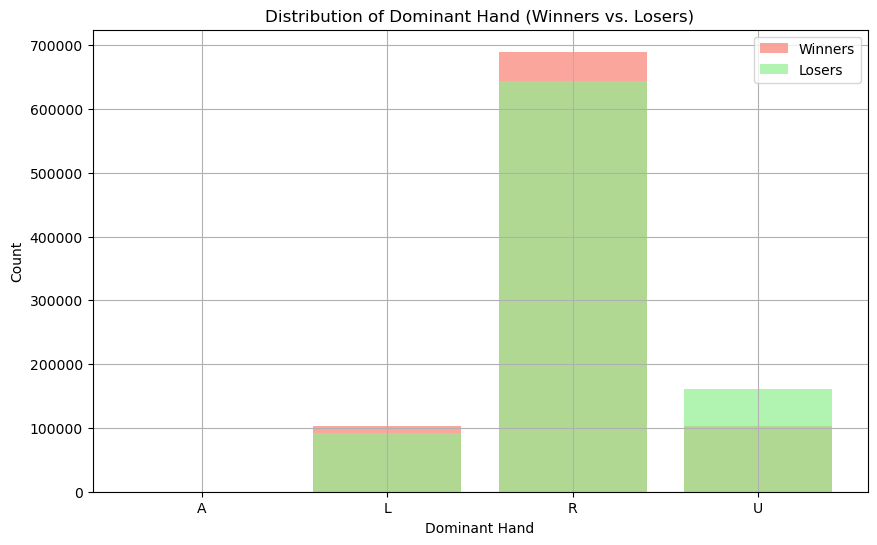

In [240]:
# Group by the winner's hand and count occurrences
winner_hand_counts = matches.groupBy('winner1_hand').count().orderBy('winner1_hand')
loser_hand_counts = matches.groupBy('loser1_hand').count().orderBy('loser1_hand')

# Convert to Pandas DataFrame
winner_hand_pandas = winner_hand_counts.toPandas()
loser_hand_pandas = loser_hand_counts.toPandas()

# Filter out NaN values
winner_hand_pandas_filtered = winner_hand_pandas.dropna(subset=['winner1_hand'])
loser_hand_pandas_filtered = loser_hand_pandas.dropna(subset=['loser1_hand'])

# Calculate the total number of winners and losers for each dominant hand
total_winners = winner_hand_pandas_filtered['count'].sum()
total_losers = loser_hand_pandas_filtered['count'].sum()

# Print the total number of winners and losers for each dominant hand
print("Total Winners:")
print(winner_hand_pandas_filtered)
print("\nTotal Losers:")
print(loser_hand_pandas_filtered)

# Define colors for winners and losers
winner_color = 'salmon'
loser_color = 'lightgreen'

# Plotting
plt.figure(figsize=(10, 6))

# Plot winners
plt.bar(winner_hand_pandas_filtered['winner1_hand'], winner_hand_pandas_filtered['count'], color=winner_color, alpha=0.7, label='Winners')

# Plot losers
plt.bar(loser_hand_pandas_filtered['loser1_hand'], loser_hand_pandas_filtered['count'], color=loser_color, alpha=0.7, label='Losers')

# Set labels and title
plt.title('Distribution of Dominant Hand (Winners vs. Losers)')
plt.xlabel('Dominant Hand')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

In [241]:
# Winning percentage on different surfaces (distributed por idade, top players)

In [242]:
# Aces and double faults distribution. - Por surface também

In [243]:
# Tournament-level statistics (e.g., average match duration, average ranking points of winners)

### Queries - Lara

In [244]:
#QUERIES, Lara
from pyspark.sql.functions import sum as spark_sum
import matplotlib.pyplot as plt

##### Roger Federer vs Rafael Nadal. Wins for each one / percentage on each surface.

Win percentage for Roger Federer by surface:
+-------+-------------+-------------+-----------------+------------------+
|surface|total_wins_rf|total_wins_rn|win_percentage_rf| win_percentage_rn|
+-------+-------------+-------------+-----------------+------------------+
|   Clay|            2|           14|             12.5|              87.5|
|   Hard|           12|            9|57.14285714285714|42.857142857142854|
|  Grass|            3|            1|             75.0|              25.0|
+-------+-------------+-------------+-----------------+------------------+



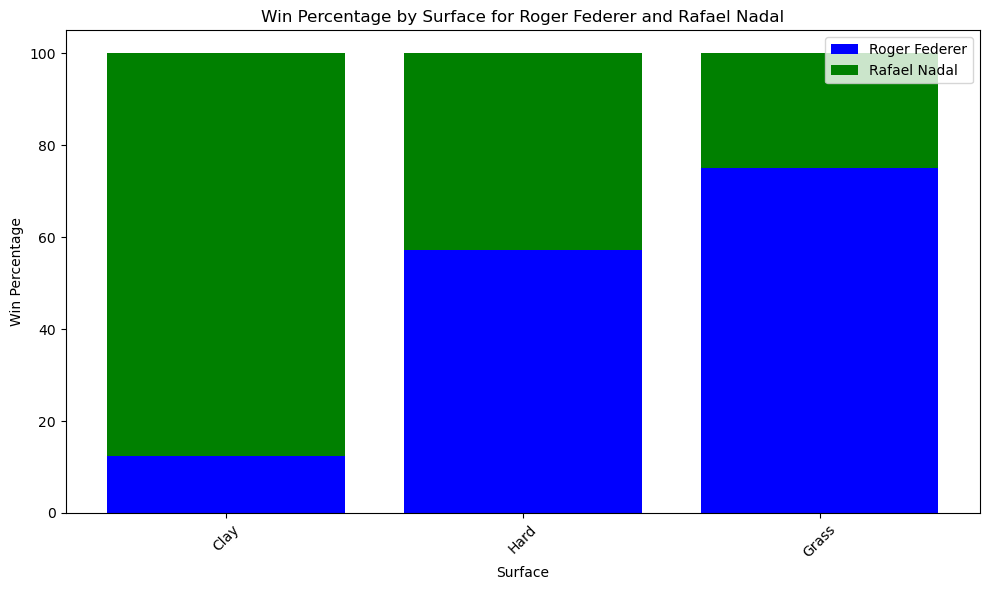

In [245]:
matches2 = matches.filter(
    ((matches.winner1_name == "Roger Federer") & (matches.loser1_name == "Rafael Nadal")) |
    ((matches.winner1_name == "Rafael Nadal") & (matches.loser1_name == "Roger Federer"))
)
# Calculate the total wins for each player on each surface
total_wins_surface = matches2.groupBy("surface").agg(
    spark_sum(F.when(matches2.winner1_name == "Roger Federer", 1).otherwise(0)).alias("total_wins_rf"),
    spark_sum(F.when(matches2.winner1_name == "Rafael Nadal", 1).otherwise(0)).alias("total_wins_rn")
)

# Calculate win percentages for each player on different surfaces
surface_wins_rf = total_wins_surface.withColumn("win_percentage_rf", (total_wins_surface["total_wins_rf"] / (total_wins_surface["total_wins_rf"] + total_wins_surface["total_wins_rn"])) * 100)
surface_wins = surface_wins_rf.withColumn("win_percentage_rn", (total_wins_surface["total_wins_rn"] / (total_wins_surface["total_wins_rf"] + total_wins_surface["total_wins_rn"])) * 100)

print("Win percentage for Roger Federer by surface:")
surface_wins.show()
# Extracting surface names and win percentages for both players
surfaces = surface_wins.select("surface").rdd.map(lambda row: row[0]).collect()
win_percentages_rf = surface_wins.select("win_percentage_rf").rdd.map(lambda row: row[0]).collect()
win_percentages_rn = surface_wins.select("win_percentage_rn").rdd.map(lambda row: row[0]).collect()

plt.figure(figsize=(10, 6))
plt.bar(surfaces, win_percentages_rf, color='blue', label='Roger Federer')
plt.bar(surfaces, win_percentages_rn, color='green', label='Rafael Nadal', bottom=win_percentages_rf)
plt.xlabel('Surface')
plt.ylabel('Win Percentage')
plt.title('Win Percentage by Surface for Roger Federer and Rafael Nadal')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [246]:
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt
import numpy as np

avg_time_per_surface = matches.groupBy("surface").agg(avg("minutes").alias("avg_time"))
avg_time_per_surface_df = avg_time_per_surface.toPandas()
print(avg_time_per_surface_df)
avg_time_per_surface_df

  surface    avg_time
0  Carpet   91.618310
1    Clay  101.223521
2    Hard   97.559373
3   Grass  104.998727
4    None         NaN


,surface,avg_time
0,Carpet,91.618310
1,Clay,101.223521
2,Hard,97.559373
3,Grass,104.998727
4,None,NaN


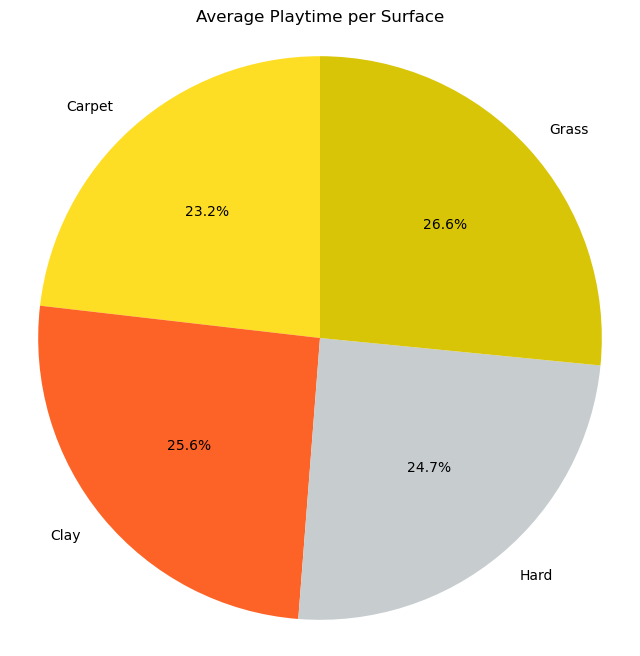

In [247]:
surfaces = avg_time_per_surface.select("surface").rdd.map(lambda row: row[0]).collect()
time = avg_time_per_surface.select("avg_time").rdd.map(lambda row: row[0]).collect()


# Filter out NaN values from the time list
valid_time = [t for t in time if isinstance(t, float) and not np.isnan(t)]

# Define colors using hex color codes
colors = ['#FEDE24', '#fd6326', '#c7cccf', '#d8c508']

# Plotting
plt.figure(figsize=(8, 8))
plt.pie(valid_time, labels=surfaces[:len(valid_time)], autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Average Playtime per Surface')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

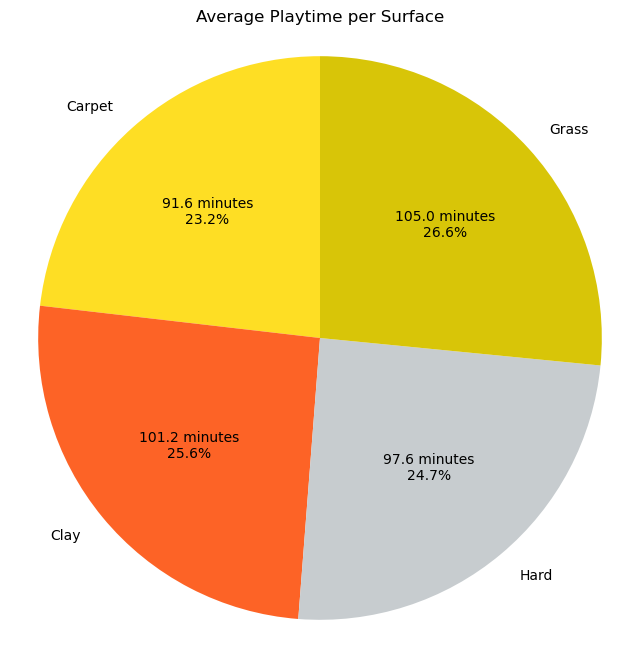

In [248]:
#add numerical time
plt.figure(figsize=(8, 8))
patches, texts, autotexts = plt.pie(valid_time, labels=surfaces[:len(valid_time)], autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Average Playtime per Surface')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adding numerical values and percentage as annotations
for i, (patch, autotext) in enumerate(zip(patches, autotexts)):
    time_value = valid_time[i]
    percentage = autotext.get_text()
    autotext.set_color('black')
    autotext.set_fontsize(10)
    autotext.set_text(f'{time_value:.1f} minutes\n{percentage}')

plt.show()

##### Top 3 players with the biggest winning percentage per surface

In [249]:
#Top 3 players with the biggest winning percentage per surface

matches_filtered = matches.filter(col("surface").isNotNull())
player_surface_stats = matches_filtered.groupBy("surface", "winner1_name")

# Calculate the total matches for each player on each surface
player_surface_stats = matches_filtered.groupBy("surface", "winner1_name").agg(
    count("*").alias("total_matches")
)

# Define a window specification to rank players by winning percentage within each surface
window_spec = Window.partitionBy("surface").orderBy(col("total_matches").desc())

# Rank the players based on total matches for each surface
ranked_players_per_surface = player_surface_stats.withColumn(
    "rank", rank().over(window_spec)
)

# Filter to get the top 3 players per surface
top_3_players_per_surface = ranked_players_per_surface.filter(col("rank") <= 4)

# Show the top 3 players per surface
top_3_players_per_surface.show()



+-------+--------------------+-------------+----+
|surface|        winner1_name|total_matches|rank|
+-------+--------------------+-------------+----+
| Carpet|       Jimmy Connors|          355|   1|
| Carpet|        John McEnroe|          352|   2|
| Carpet|          Ivan Lendl|          271|   3|
| Carpet|         Arthur Ashe|          258|   4|
| Carpet|        Boris Becker|          258|   4|
|   Clay|Ruben Ramirez Hid...|          682|   1|
|   Clay|     Guillermo Vilas|          676|   2|
|   Clay|      Carlos Berlocq|          626|   3|
|   Clay|      Manuel Orantes|          580|   4|
|  Grass|        Ken Rosewall|          216|   1|
|  Grass|       John Newcombe|          211|   2|
|  Grass|         Roy Emerson|          205|   3|
|  Grass|       Roger Federer|          201|   4|
|   Hard|       Roger Federer|          848|   1|
|   Hard|           Bob Bryan|          770|   2|
|   Hard|      Novak Djokovic|          739|   3|
|   Hard|         Yen Hsun Lu|          623|   4|


In [250]:
#that's not it. let's try differently
matches_filtered = matches.filter(col("surface").isNotNull())

player_surface_stats = matches_filtered.groupBy("surface", "winner1_name").agg(
    count("*").alias("total_wins")
)

player_surface_stats.show(2)

loser_surface_stats = matches_filtered.groupBy("surface", "loser1_name").agg(
    count("*").alias("total_losses")
)

loser_surface_stats.show(2)


+-------+---------------+----------+
|surface|   winner1_name|total_wins|
+-------+---------------+----------+
| Carpet|Tomas Carbonell|        18|
| Carpet|  Karel Novacek|        57|
+-------+---------------+----------+
only showing top 2 rows

+-------+---------------+------------+
|surface|    loser1_name|total_losses|
+-------+---------------+------------+
| Carpet|Tomas Carbonell|          33|
| Carpet|  Karel Novacek|          64|
+-------+---------------+------------+
only showing top 2 rows



In [251]:
# Join the winner and loser statistics
player_stats = player_surface_stats.join(
    loser_surface_stats,
    (player_surface_stats.surface == loser_surface_stats.surface) &
    (player_surface_stats.winner1_name == loser_surface_stats.loser1_name),
    "full_outer"
).groupBy(player_surface_stats.surface, player_surface_stats.winner1_name.alias("player_name")).agg(
    (sum(player_surface_stats.total_wins) + sum(loser_surface_stats.total_losses)).alias("total_games"),
    sum(player_surface_stats.total_wins).alias("total_wins")
)

# Show the top 4 rows of the resulting DataFrame
player_stats.show(10)


+-------+--------------------+-----------+----------+
|surface|         player_name|total_games|total_wins|
+-------+--------------------+-----------+----------+
| Carpet|Alexandros Georgo...|          4|         1|
| Carpet|        Daniel Fiala|          8|         1|
| Carpet|         Dejan Katic|          5|         2|
| Carpet|Fernando Dalla Fo...|       NULL|         1|
| Carpet|       Frederico Gil|          2|         1|
| Carpet| Ivan Gomez Mantilla|          6|         2|
| Carpet|         Juraj Hasko|         10|         6|
| Carpet|       Karel Novacek|        121|        57|
| Carpet|          Pavel Riha|         57|        31|
| Carpet|Rafael Avalos Brenes|          3|         1|
+-------+--------------------+-----------+----------+
only showing top 10 rows



In [252]:
# Calculate winning percentage
player_stats = player_stats.withColumn(
    "winning_percentage",
    (col("total_wins") / col("total_games")) * 100
)

window_spec = Window.partitionBy(player_stats.surface).orderBy(player_stats.winning_percentage.desc())

# Assign ranks to players within each surface based on winning_percentage
player_stats_ranked = player_stats.withColumn("rank", rank().over(window_spec))

# Filter to show only the top 3 players for each surface, considering ties
player_stats_filtered = player_stats_ranked.filter((col("rank") <=3))

# Show the resulting DataFrame
player_stats_filtered.show()

+-------+--------------------+-----------+----------+------------------+----+
|surface|         player_name|total_games|total_wins|winning_percentage|rank|
+-------+--------------------+-----------+----------+------------------+----+
|   NULL|                NULL|       NULL|      NULL|              NULL|   1|
| Carpet|     Krister Wedenby|         19|        17| 89.47368421052632|   1|
| Carpet|  Yoshihito Nishioka|          8|         7|              87.5|   2|
| Carpet|Frederico Ferreir...|          8|         7|              87.5|   2|
| Carpet|  Dmitri Tomashevich|          8|         7|              87.5|   2|
|   Clay|        Tony Trabert|         22|        20|  90.9090909090909|   1|
|   Clay|   Jean Rene Lacoste|         52|        47| 90.38461538461539|   2|
|   Clay|   Henri Jean Cochet|         65|        58| 89.23076923076924|   3|
|  Grass|           Don Budge|         71|        64| 90.14084507042254|   1|
|  Grass|Richard Pancho Go...|         20|        18|           

In [253]:
#Percentage of times where a player lost the first set in a 3-set game and ended up winning the match.

filtered_matches = matches.filter(
    (col("set_1").isNotNull()) &
    (col("set_2").isNotNull()) &
    (col("set_3").isNotNull()) &
    (col("set_4").isNull()) &
    (col("set_5").isNull()) &
    col("set_3").like("%-%")
)

lost_first_set_and_won_match = filtered_matches.filter(
    (col("set_1").like("%-6") & col("set_2").like("6-%") & col("set_3").like("6-%")) |
    (col("set_1").like("6-%") & col("set_2").like("%-6") & col("set_3").like("%-6"))
)

total_matches_count = lost_first_set_and_won_match.count()

win_percentage = (total_matches_count / filtered_matches.count()) * 100

print("Percentage of times where a player lost the first set in a 3-set game and ended up winning the match:", win_percentage, "%")


Percentage of times where a player lost the first set in a 3-set game and ended up winning the match: 20.75711065942119 %


In [254]:
#Percentage of times where a player lost the first set in a 3-set game and ended up winning the match.
#variation
filtered_matches = matches.filter(
    (col("set_1").like("%-%")) &
    (col("set_2").like("%-%")) &
    (col("set_3").like("%-%")) &
    (col("set_4").isNull()) &
    (col("set_5").isNull())
)

lost_first_set_and_won_match = filtered_matches.filter(
    (col("set_1").like("%-6") & col("set_2").like("6-%") & col("set_3").like("6-%")) |
    (col("set_1").like("6-%") & col("set_2").like("%-6") & col("set_3").like("%-6"))
)

total_matches_count = lost_first_set_and_won_match.count()

win_percentage = (total_matches_count / filtered_matches.count()) * 100

print("Percentage of times where a player lost the first set in a 3-set game and ended up winning the match:", win_percentage, "%")


Percentage of times where a player lost the first set in a 3-set game and ended up winning the match: 20.758689354287807 %


In [255]:
#Percentage of times where a player lost the first two sets in a 5-set game and ended up winning the match.
#casos com vantagens(?) não são considerados... ex: 7-6(1)

filtered_matches = matches.filter(
    (col("set_1").like("%-%")) &
    (col("set_2").like("%-%")) &
    (col("set_3").like("%-%")) &
    (col("set_4").like("%-%")) &
    (col("set_5").like("%-%")) 
)

lost_first_set_and_won_match = filtered_matches.filter(
    (col("set_1").like("%-6") & col("set_2").like("%-6") & col("set_3").like("6-%") & col("set_4").like("6-%")& col("set_5").like("6-%")) |
    (col("set_1").like("6-%") & col("set_2").like("6-%") & col("set_3").like("%-6") & col("set_4").like("%-6")& col("set_5").like("%-6"))
)

total_matches_count = lost_first_set_and_won_match.count()

win_percentage = (total_matches_count / filtered_matches.count()) * 100

print("% of times where a player lost the first two sets in a 5-set game and ended up winning the match:", win_percentage, "%")

% of times where a player lost the first two sets in a 5-set game and ended up winning the match: 5.786054569077523 %


### Queries - Bea

#### Players with the biggest average of aces per match and their height

+--------------------+----------+------------------+
|        winner1_name|winner1_ht|avg_aces_per_match|
+--------------------+----------+------------------+
|        Ismar Gorcic|      NULL|23.333333333333332|
|        Ivo Karlovic|       208| 20.30878859857482|
|          Tyler Zink|      NULL|              19.0|
|          John Isner|       206|18.901768172888016|
|       Reilly Opelka|       211|18.550632911392405|
|        Heath Denman|       183|              18.0|
|Herbert Jody Magi...|      NULL|              18.0|
|          Jay Clarke|      NULL|              18.0|
|       Wayne Arthurs|       190|             17.35|
|       Scott Oudsema|       190|              17.0|
+--------------------+----------+------------------+



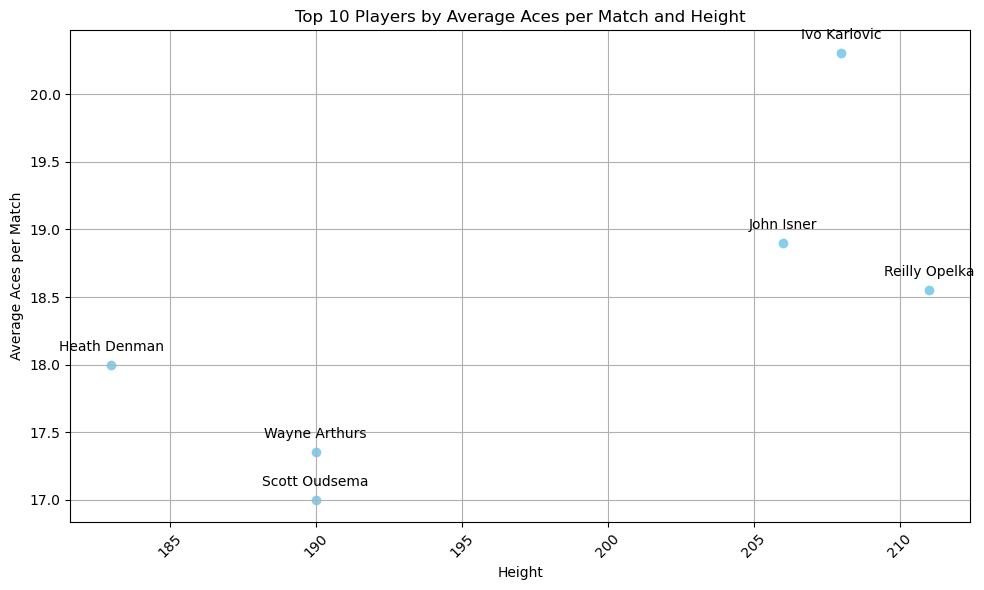

In [256]:
# Group by winner name and calculate the average number of aces per match
aces_per_match = matches.groupBy('winner1_name', 'winner1_ht') \
                        .agg(F.avg('w_ace').alias('avg_aces_per_match'))

top_players = aces_per_match.orderBy(F.desc('avg_aces_per_match')).limit(10)
top_players.show()


# ------ Plot --------

# Filter out missing values from player_height
player_names = [row['winner1_name'] for row in top_players.collect()]
avg_aces = [row['avg_aces_per_match'] for row in top_players.collect()]
player_height = [row['winner1_ht'] for row in top_players.collect()]

valid_indices = [i for i, height in enumerate(player_height) if height is not None]
player_names = [player_names[i] for i in valid_indices]
avg_aces = [avg_aces[i] for i in valid_indices]
player_height = [player_height[i] for i in valid_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(player_height, avg_aces, color='skyblue')

# Annotating each data point with player names
for i, txt in enumerate(player_names):
    plt.annotate(txt, (player_height[i], avg_aces[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Height')
plt.ylabel('Average Aces per Match')
plt.title('Top 10 Players by Average Aces per Match and Height')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### 5 oldest pairs (average age) winning a tournament.

+---------------+-------------+-----------------+
|   winner1_name| winner2_name|      average_age|
+---------------+-------------+-----------------+
|   Ivo Karlovic|Daniel Nestor|   42.35181382615|
|   Leander Paes|     Andre Sa|   41.77549623545|
|  Daniel Nestor| Leander Paes|41.55762649397308|
|James Cerretani|Daniel Nestor|   41.11293634495|
|James Cerretani| Leander Paes|    40.8090349076|
+---------------+-------------+-----------------+



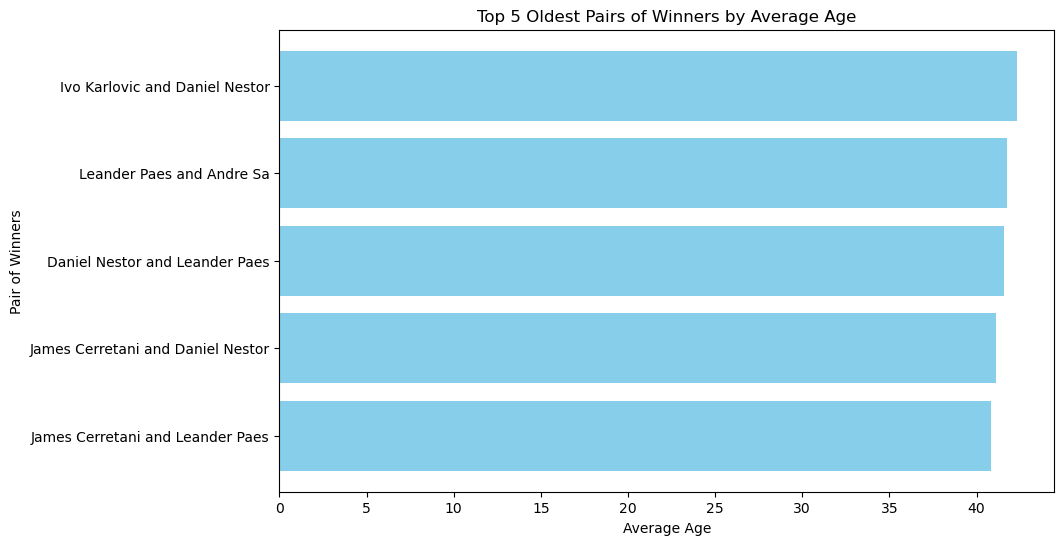

In [257]:
# Calculate the average age for each pair of winners
matches = matches.withColumn("avg_age", (F.col("winner1_age") + F.col("winner2_age")) / 2)

pairs_avg_age = matches.groupBy("winner1_name", "winner2_name").agg(F.avg("avg_age").alias("average_age"))
oldest_pairs = pairs_avg_age.orderBy(F.desc("average_age")).limit(5)
oldest_pairs.show()

# Convert the result to Pandas DataFrame
oldest_pairs_df = oldest_pairs.toPandas()

pairs = oldest_pairs_df["winner1_name"] + " and " + oldest_pairs_df["winner2_name"]
average_age = oldest_pairs_df["average_age"]

plt.figure(figsize=(10, 6))
plt.barh(pairs, average_age, color='skyblue')
plt.xlabel('Average Age')
plt.ylabel('Pair of Winners')
plt.title('Top 5 Oldest Pairs of Winners by Average Age')
plt.gca().invert_yaxis()  # Invert y-axis to display highest age at the top
plt.show()

#### Percentage of matches that have 3 sets.

In [258]:
# Calculate the total number of matches
total_matches = matches.count()

# Matches with 3 sets
matches_with_3_sets = matches.filter(expr("set_3 IS NOT NULL")).count()
percentage_3_sets = (matches_with_3_sets / total_matches) * 100
print(f"Percentage of matches with 3 sets: {percentage_3_sets:.2f}%")

Percentage of matches with 3 sets: 36.92%


#### How many times did Rafael Nadal lose two games in a row on Clay and how many games in total? (0 in hundreds)

In [259]:
rafael_matches = matches.filter((matches.loser1_name == 'Rafael Nadal'))
total_games_lost = rafael_matches.agg(F.sum('l_SvGms')).collect()[0][0]

rafael_losses_on_clay = rafael_matches.filter(rafael_matches.surface == 'Clay')

# Define a window function to partition by the player's name and order by the tournament date
windowSpec = Window.partitionBy('loser1_name').orderBy('tourney_date')

# Create a column to indicate if the player lost two games in a row
rafael_losses_on_clay = rafael_losses_on_clay.withColumn('consecutive_losses', 
                                                         F.when((F.lag('tourney_date').over(windowSpec) == F.col('tourney_date') - 1), 1).otherwise(0))

# Filter the DataFrame to include only consecutive losses
two_losses_in_row = rafael_losses_on_clay.filter(rafael_losses_on_clay.consecutive_losses == 1)
total_two_losses_in_row = two_losses_in_row.count()


print("Total games lost by Rafael Nadal:", total_games_lost)
print("Total instances of two consecutive losses on Clay:", total_two_losses_in_row)

Total games lost by Rafael Nadal: 2836
Total instances of two consecutive losses on Clay: 0


#### Top 10 games with longest duration and their final score. (first one is 11 hours +)

In [260]:
# Split the score column into winner and loser scores
matches = matches.withColumn('winner_score', F.split('score', '-').getItem(0))
matches = matches.withColumn('loser_score', F.split('score', '-').getItem(1))

game_durations = matches.groupBy('tourney_id', 'winner1_name', 'score', 'winner_score', 'loser_score') \
                        .agg(F.max('minutes').alias('max_duration'))

game_durations = game_durations.withColumn('max_duration_hours', game_durations['max_duration'] / 60)
top_longest_games = game_durations.orderBy(F.desc('max_duration')).limit(10)

top_longest_games.show()

+----------+--------------------+--------------------+------------+-----------+------------+------------------+
|tourney_id|        winner1_name|               score|winner_score|loser_score|max_duration|max_duration_hours|
+----------+--------------------+--------------------+------------+-----------+------------+------------------+
| 2018-7391|      Federico Coria|             6-4 6-3|           6|        4 6|        4756| 79.26666666666667|
| 2023-9542|Camilo Ugo Carabelli|      6-3 5-7 7-6(5)|           6|        3 5|        1531|25.516666666666666|
| 2016-7347|      Juan Pablo Paz|             6-2 6-1|           6|        2 6|        1392|              23.2|
| 2018-7015|       Federico Gaio|      6-4 6-7(6) 7-5|           6|        4 6|        1241|20.683333333333334|
| 2016-0447|        Dmitry Popko|             6-2 6-3|           6|        2 6|        1237|20.616666666666667|
| 2016-M001|       Gilles Muller|          7-6(5) 6-3|           7|     6(5) 6|        1146|            

#### Average ranking of winners and losers (finalists) per tournament type (tourney_level).

In [261]:
# Calculate average ranking of winners and finalists per tournament type
avg_ranking_per_type = matches.groupBy('tourney_level') \
    .agg(
        F.avg('winner1_rank').alias('avg_winner_rank'),
        F.avg('loser1_rank').alias('avg_loser_rank')
    )

avg_ranking_per_type.show()

+-------------+------------------+------------------+
|tourney_level|   avg_winner_rank|    avg_loser_rank|
+-------------+------------------+------------------+
|            F|  9.84879288437103|15.144853875476493|
|            M|52.782369971049214| 82.53227762803235|
|            D|262.78830718715795|387.00380476138713|
|            A| 92.73410764046152|143.27926820391295|
|            G| 93.89269283162413|136.63778158345409|
|            S|  656.462971366281| 829.0578240108748|
|           15| 810.4517775074345| 985.4744022130433|
|            C|  262.144446733979| 336.1185596775714|
+-------------+------------------+------------------+



##### Show the top 5 winners for each tourney_level with an Winner rank supperior from the average

In [262]:
avg_winner_rank_per_type = matches.groupBy('tourney_level').agg(F.avg('winner1_rank').alias('avg_winner_rank'))

window = Window.partitionBy('tourney_level').orderBy(F.desc('winner1_rank'))

# Add a rank column based on winner1_rank in descending order
matches_with_rank = matches.withColumn('rank', F.rank().over(window))
matches_with_rank = matches_with_rank.join(avg_winner_rank_per_type, on='tourney_level')

filtered_players = matches_with_rank.filter(matches_with_rank['winner1_rank'] > matches_with_rank['avg_winner_rank'])
top_players_per_type = filtered_players.filter(filtered_players['rank'] <= 3)

distinct_top_players = top_players_per_type.select('tourney_level', 'winner1_name', 'winner1_rank').distinct()
distinct_top_players.show()

+-------------+--------------------+------------+
|tourney_level|        winner1_name|winner1_rank|
+-------------+--------------------+------------+
|            F|    Hamad Medjedovic|         110|
|            F|          Luca Nardi|         115|
|            F|  Abedallah Shelbayh|         185|
|            M|    David Nalbandian|        1403|
|            M|         Todd Martin|        1427|
|            D| Sharmal Dissanayake|        2018|
|            D|Antso Rakotondram...|        2018|
|            D|         Roberto Cid|        2091|
|            D|     Shahin Khaledan|        2101|
|            A|     Nino Serdarusic|        2128|
|            A|     Sebastian Lavie|        2152|
|            G|        Ian Flanagan|        1711|
|            G|       Edward Winter|        1768|
|            G|    Mitchell Krueger|        1917|
|            S|    Davide Galoppini|        2252|
|            S|    Santiago Maresca|        2255|
|            S|Mostafa Mohamed H...|        2257|


#### Top 5 youngest number 1 in the world and their age on that moment

In [263]:
number_1_players = matches.filter(matches['winner1_rank'] == 1)

# Group the data by player and find the minimum age when they were ranked number 1
youngest_number_1_players = number_1_players.groupby('winner1_name') \
    .agg(F.min('winner1_age').alias('age_when_number_1')) \
    .orderBy('age_when_number_1') \
    .limit(5)

youngest_number_1_players.show()

+--------------+-----------------+
|  winner1_name|age_when_number_1|
+--------------+-----------------+
|Carlos Alcaraz|             19.3|
|Lleyton Hewitt|             20.7|
|   Marat Safin|             20.8|
|  Andy Roddick|             21.1|
|   Jim Courier|             21.4|
+--------------+-----------------+



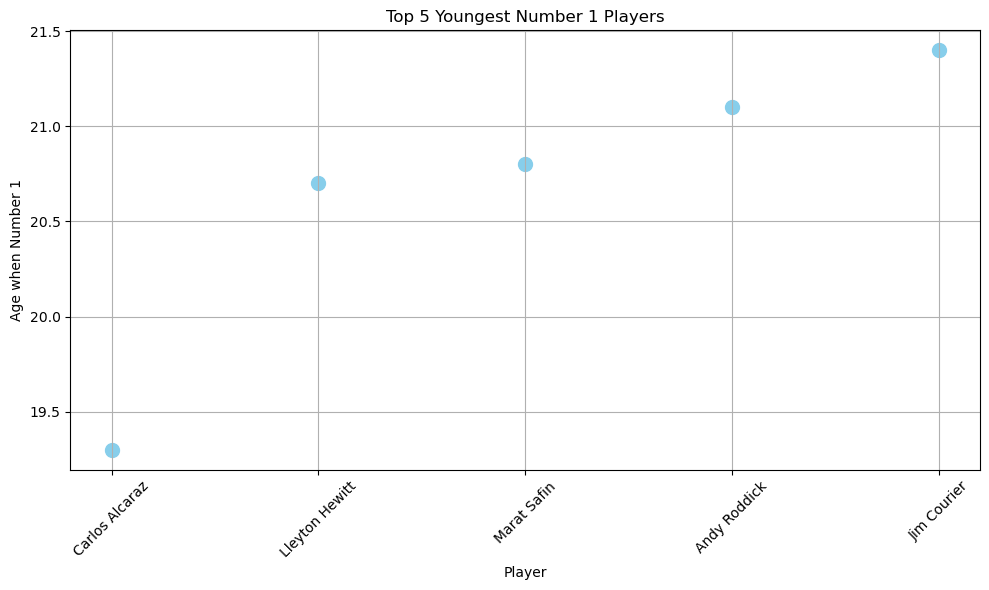

In [264]:
youngest_number_1_players_pd = youngest_number_1_players.toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(youngest_number_1_players_pd['winner1_name'], youngest_number_1_players_pd['age_when_number_1'], s=100, color='skyblue')
plt.title('Top 5 Youngest Number 1 Players')
plt.xlabel('Player')
plt.ylabel('Age when Number 1')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Identifying nationalities with over 100 distinct winners within year groups (every 5 years)

In [265]:
# Window function to calculate year group
windowSpec = Window.partitionBy('year').orderBy('year').rowsBetween(-4, 0)

nationality_counts = matches_with_year.withColumn("year_group", F.floor(F.col('year') / 5) * 5).groupBy('year_group', 'winner1_ioc') \
    .agg(F.countDistinct('winner1_name').alias('count'))
nationality_counts = nationality_counts.withColumnRenamed('winner1_ioc', 'winner_nationality')


# Filter for the top 100 in each year group
top_100_nationalities = nationality_counts.orderBy(nationality_counts['count'].desc()) \
  .filter(nationality_counts['count'] > 100)
top_100_nationalities.show()

+----------+------------------+-----+
|year_group|winner_nationality|count|
+----------+------------------+-----+
|      1990|               USA|  375|
|      2015|               USA|  364|
|      1995|               USA|  350|
|      2010|               USA|  306|
|      2000|               USA|  282|
|      2020|               USA|  269|
|      2005|               USA|  268|
|      1980|               USA|  265|
|      1910|               USA|  259|
|      1985|               USA|  258|
|      2015|               FRA|  245|
|      2015|               ITA|  242|
|      1965|               USA|  242|
|      2010|               FRA|  228|
|      1905|               USA|  223|
|      1995|               GER|  223|
|      2000|               ESP|  215|
|      1975|               USA|  215|
|      2020|               ITA|  208|
|      2005|               GER|  201|
+----------+------------------+-----+
only showing top 20 rows



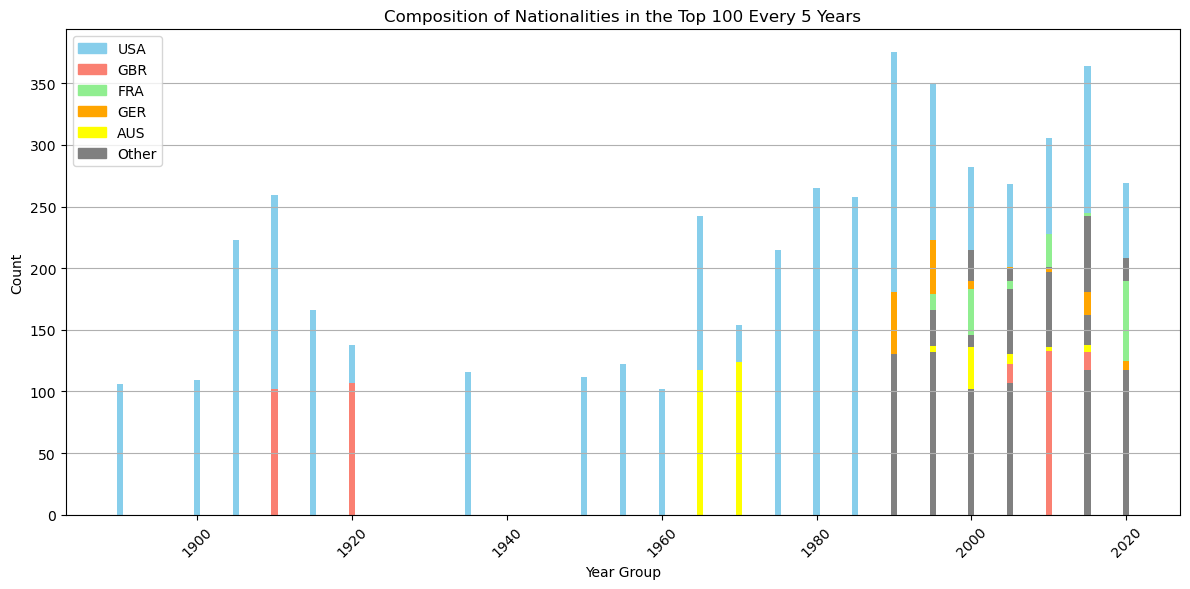

In [266]:
# Drop rows with missing or invalid values in the 'winner_nationality' column
top_100_nationalities_pandas = top_100_nationalities_pandas.dropna(subset=['winner_nationality'])

color_map = {'USA': 'skyblue', 'GBR': 'salmon', 'FRA': 'lightgreen', 'GER': 'orange', 'AUS': 'yellow'}

plt.figure(figsize=(12, 6))
bars = plt.bar(top_100_nationalities_pandas['year_group'], top_100_nationalities_pandas['count'],
               color=top_100_nationalities_pandas['winner_nationality'].map(color_map, na_action='ignore').fillna('grey'))
plt.title('Composition of Nationalities in the Top 100 Every 5 Years')
plt.xlabel('Year Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')

legend_labels = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
legend_labels.append(plt.Rectangle((0,0),1,1, color='grey'))
color_map['Other'] = 'grey'
plt.legend(legend_labels, list(color_map.keys()) + ['Other'], loc='upper left')

plt.tight_layout()
plt.show()